# Introduction: Grammar of Spatial Data Science

## 1. Learning Objectives

This lecture provides students with **little-to-zero prior knowledge** core competences in Spatial Data Science (SDS).

a. Advance their numerical, computational, and statistical literacy. <br>
b. Introduce basic principles of programming and state of the art (SOTA) computational tools for SDS. <br>
c. Present a rich overview of the methodologies available to the Spatial Data Scientist, as well as intuition as to how and when they can be applied. <br>
d. Focus on real world applications of these techniques in a geographical and applied context.

## 2. Learning Outcomes

By the end of the lecture & workshop, students will be able to:

a. Demonstrate SDS concepts and be able to use tools programmatically to import, manipulate, and analyze spatial data in different formats. <br>
b. Understand the motivation and inner workings of the main methodological approcahes of SDS, both analytical and visual. <br>
3. Apply spatial analysis techniques and explain how to interpret the results, in a process of turning data into information.

In [1]:
# for reproducibility
import random
random.seed(2023)

# for text matching 
import re

# for downloading data and parsing dictionary
import json
import requests

# for spatial data I/O, manipulation, and visualization
import shapely
import leafmap
import osmnx as ox
import networkx as nx
import contextily as ctx
import geopandas as gpd
from shapely.geometry import (
    Point, LineString, Polygon
)
from gadm import GADMDownloader

# standard python libraries
import numpy as np
import pandas as pd
pd.options.display.max_colwidth=200
pd.options.display.max_columns=100
from itertools import combinations
import matplotlib.pyplot as plt

# custom lib for the lecture
# from sds4gdsp import loader, processor

In [2]:
def make_points(num_points, lng_min, lng_max, lat_min, lat_max):
    coords = []
    for _ in range(num_points):
        lng = random.uniform(lng_min, lng_max)
        lat = random.uniform(lat_min, lat_max)
        coords.append((lng, lat))
    return coords

def make_lines(points):
    random.shuffle(points)
    lines = []
    for orig, dest in zip(points, points[1:]):
        if random.choices([True, False], [30, 70], k=1)[0]:
            lines.append(LineString([orig, dest]))
    return lines

def make_polygon(points):
    return Polygon(points)

def make_spatial_data(n):
    coords = np.random.random((n, 2))
    points = list(map(lambda z: Point(z), coords))
    lines = LineString(points)
    lines = list(map(lambda x: LineString(x), list(zip(points, points[1:]))))
    polygon = Polygon(points)
    return points, lines, polygon

def make_graph(
    origin, network_type, dist=500, dist_type="bbox", retain_all=False, simplify=True
):
    # query the road network using OSMNx
    G = ox.graph_from_point(
        center_point=origin, # origin point of query
        dist=dist, # radius in meters from the origin
        dist_type=dist_type, # examples is `bbox`
        retain_all=retain_all, # filter connected components?
        simplify=simplify, # simplify network topology
        network_type=network_type # filter to <insert type from OSM> roads
    )
    return G

def get_coord_sequence(G, route):
    route_coords = []
    for node in route:
        route_coords.append((G.nodes[node]["x"], G.nodes[node]["y"]))
    return route_coords

## 3. Motivation

### a. What makes SDS so spatial (special)?

a. SDS aims to answer the twofold question -> **WHERE and WHY things happen?**

SDS is interested in understanding both where certain things (or events) happen and why they happen in those places. To do this, Spatial Data Scientists leverage location, distance, and spatial interactions as core aspects of the data they work with and use highly specialized methods and cutting-edge software to analyze, visualize, and draw actionable insights from various spatial use cases.

b. SDS is the intersection of Data Science (DS) and **Geographic Information System (GIS).**

GIS is a niche field that refers to different types of information systems, such as websites, apps, or databases for storing and processing spatial datasets. Today, Spatial Data Scientists use GIS as part of a wider, more modern tech stack allowing them to do more advanced statistical and modeling-based data analyses while also being able to leverage the latest artificial intelligence (AI) and machine learning (ML) techniques more effectively.

c. Only **1 in 3 Data Scientists** are experts in spatial analysis.

SDS is clearly still a niche area of data science, it is nonetheless an attractive area for organizations to explore and focus on in the years ahead. According to this survey **[HI PAO, INSERT LINK PLEASE]**, 9 in 10 of the industries surveyed (telco, software & tech, consulting, cities & government, etc.)
- Have a difficult time finding, recruiting, and hiring talent with SDS in their toolbelt  
- Very likely to increase their investment in SDS for the next two years

d. There's a ton of **publicly available** geo datasets out there!

Yes! That's true. Be it points of interest (POI) like buildings, man-made road networks, internet submarine cables, etc

### Q1: Where (might) have you used geospatial data before?

- Answer #1
- Answer #2
- Answer #n

### b. How can I relate this to my work in Globe?

Geospatial data and assets in the telco universe is **ubiquitous.**

Here are some examples you can encounter in the wild.

**POINT** representation

- Globe cellsites
- Globe fiber NAPs
- Globe physical stores
- Globe sub households
- Globe blitz deployments
- Globe OOH advertisements
- Web-scraped POIs

**POLYGON** representation

- PH admin boundaries
- Globe cellsite coverage areas
- Globe fiber coverage areas
- Custom enumeration units (rectangles, hexagons, etc)
- Competitor coverage estimates
- Building footprints

**GRAPH** representation

- PH road networks
- Globe fiber wiring connections
- WW submarine cable network

### Q2: Can you find the USD 150 million PDSCN project?

The [**Philippine Domestic Submarine Cable Network (PDSCN)**](https://www.globe.com.ph/about-us/newsroom/corporate/pdscn-for-april-2023-completion.html#gref) is the longest undersea fiber cable network in the Philippines to date, spanning a total of 2,500 KM.

In [3]:
M = leafmap.Map(center=[0, 0], zoom=2)
filepath_cable = "https://raw.githubusercontent.com/opengeos/leafmap/master/examples/data/cable_geo.geojson"
M.add_geojson(filepath_cable, layer_name="WW internet submarine cables")
display(M)

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

If you have a hard time finding it, get your hands dirty!

1. Load the GeoJSON file using the URL filepath earlier.
2. Parse the dictionary, look for the keyword using regex
3. Use this key to fetch the necessary geometry

In [4]:
response = requests.get(filepath_cable)
submarine_cables = json.loads(response.text)

# apply 'Philippine' regex to this list, you'll find it for sure!
names_submarine_cables = list(map(lambda x: x["properties"]["name"], submarine_cables["features"]))

r = re.compile(".*Philippine")
key_pdscn = list(filter(r.match, names_submarine_cables))[0]

In [5]:
key_pdscn

'Philippine Domestic Submarine Cable Network (PDSCN)'

In [6]:
for test in list(map(lambda x: x["properties"], submarine_cables["features"])):
    if test["name"] == key_pdscn:
        geojson_pdscn = test

In [7]:
geojson_pdscn # hooray! you can use the coordinate data and plot it to any of your favorite geo library

{'id': 'philippine-domestic-submarine-cable-network-pdscn',
 'name': 'Philippine Domestic Submarine Cable Network (PDSCN)',
 'color': '#939597',
 'feature_id': 'philippine-domestic-submarine-cable-network-pdscn-0',
 'coordinates': [121.84808636692307, 7.691515447263953]}

### Q3: Can you think of any telco geospatial data that is not yet included?

- Answer #1
- Answer #2
- Answer #n

## 4. Familiarizing yourself with **nouns**

### c. Shapely and basic geometric objects

With the use of the **Shapely** library, you can work with geometric objects such as points, lines, and polygons. Most of the data you'll work with can be modeled using these object representations.

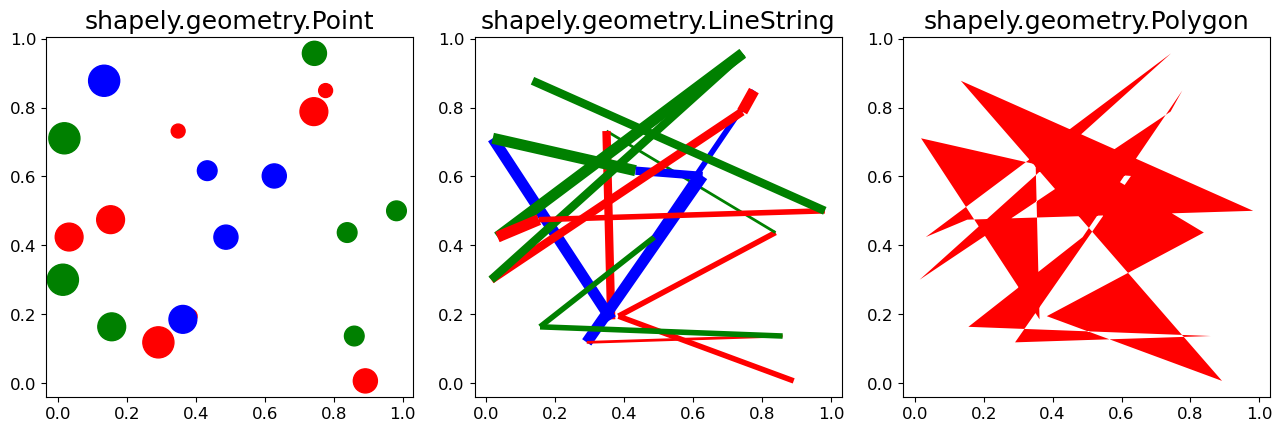

In [8]:
n = 20
points, lines, polygon = make_spatial_data(n)

fig, ax = plt.subplots(1, 3, figsize=(13, 9))
colors = [random.choice(["red", "green", "blue"]) for _ in range(n)]
markersizes = [random.choice(range(100, 600, 100)) for _ in range(n)]
gpd.GeoSeries(points).plot(ax=ax[0], markersize=markersizes, color=colors)
linewidths = [random.choice(range(2, 10, 2)) for _ in range(n)]
gpd.GeoSeries(lines).plot(ax=ax[1], linewidth=linewidths, color=colors)
gpd.GeoSeries(polygon).plot(ax=ax[2], linewidth=5, color=random.choice(colors))
ax[0].set_title(f"shapely.geometry.Point", fontsize=18)
ax[1].set_title(f"shapely.geometry.LineString", fontsize=18)
ax[2].set_title(f"shapely.geometry.Polygon", fontsize=18)
ax[0].tick_params(axis="both", which="major", labelsize=12)
ax[0].tick_params(axis="both", which="minor", labelsize=12)
ax[1].tick_params(axis="both", which="major", labelsize=12)
ax[1].tick_params(axis="both", which="minor", labelsize=12)
ax[2].tick_params(axis="both", which="major", labelsize=12)
ax[2].tick_params(axis="both", which="minor", labelsize=12)
plt.tight_layout();

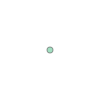

In [11]:
points[0]

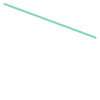

In [12]:
lines[0]

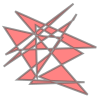

In [13]:
polygon

### Q4: Lorem Ipsum?

### d. Geopandas and dataframes

This tool allows you to process tabular geometric data with a Pandas API like interface. Let's look at an example using the GADM shapefile (PH).

In [14]:
country_name = "Philippines"
gadm_version = "4.0"
ad_level = 2
downloader = GADMDownloader(version=gadm_version)
gadm = downloader.get_shape_data_by_country_name(
    country_name=country_name, ad_level=ad_level
)

In [15]:
gadm.head()

,ID_0,COUNTRY,NAME_1,NL_NAME_1,ID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,PHL,Philippines,Abra,,PHL.1.1_1,Bangued,,,Bayan|Munisipyo,Municipality,140101,PH.AB.BN,"MULTIPOLYGON (((120.61134 17.49558, 120.60941 17.49690, 120.60811 17.49820, 120.60652 17.49995, 120.60549 17.50203, 120.60761 17.50848, 120.60712 17.51232, 120.60735 17.51533, 120.60841 17.51812, ..."
1,PHL,Philippines,Abra,,PHL.1.2_1,Boliney,,,Bayan|Munisipyo,Municipality,140102,PH.AB.BL,"MULTIPOLYGON (((120.81400 17.34210, 120.76862 17.34028, 120.76534 17.36494, 120.76339 17.38189, 120.76253 17.39650, 120.76131 17.41677, 120.76293 17.41664, 120.76375 17.41648, 120.76431 17.41608, ..."
2,PHL,Philippines,Abra,,PHL.1.3_1,Bucay,,,Bayan|Munisipyo,Municipality,140103,PH.AB.BU,"MULTIPOLYGON (((120.67766 17.45736, 120.67324 17.46966, 120.67500 17.47158, 120.67467 17.47305, 120.67429 17.47495, 120.67432 17.47645, 120.67471 17.47948, 120.67455 17.48215, 120.67427 17.48480, ..."
3,PHL,Philippines,Abra,,PHL.1.4_1,Bucloc,,,Bayan|Munisipyo,Municipality,140104,PH.AB.BC,"MULTIPOLYGON (((120.78922 17.44525, 120.80331 17.44937, 120.81813 17.45325, 120.82371 17.45433, 120.84486 17.45968, 120.86623 17.46478, 120.88464 17.46942, 120.89281 17.44643, 120.90749 17.41933, ..."
4,PHL,Philippines,Abra,,PHL.1.5_1,Daguioman,,,Bayan|Munisipyo,Municipality,140105,PH.AB.DG,"MULTIPOLYGON (((120.90749 17.41933, 120.89281 17.44643, 120.88464 17.46942, 120.90692 17.47638, 120.92271 17.48230, 120.93330 17.48646, 120.98009 17.50482, 120.98145 17.50448, 120.98141 17.50534, ..."


Our dataset contains the city/town level boundaries (L2 in GADM). Let's look at the dtype of one geom object.

<class 'shapely.geometry.multipolygon.MultiPolygon'>


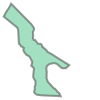

In [16]:
print(type(gadm.loc[0, "geometry"]))
gadm.loc[0, "geometry"]

Like pandas, we can perform `.plot()` in geopandas. Let's look into the PH boundaries.

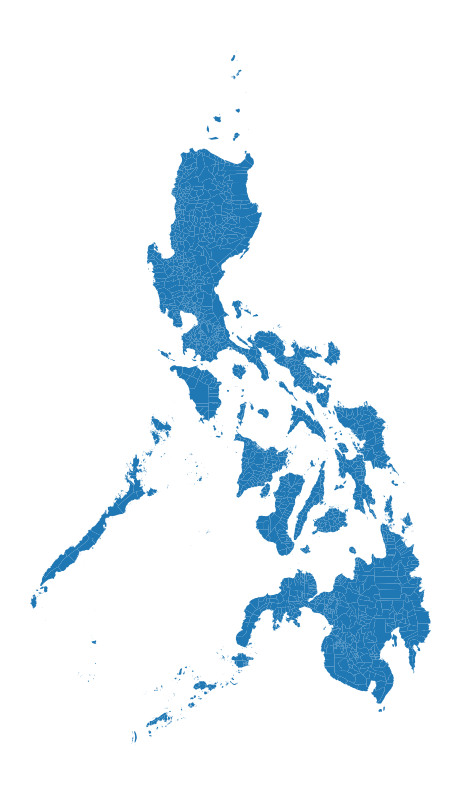

In [17]:
fig, ax = plt.subplots(1, figsize=(7, 10))
gadm.plot(ax=ax)
ax.axis("off");

In [18]:
is_metro_manila = gadm.NAME_1=="Metropolitan Manila"
gadm_metro_manila = gadm.loc[is_metro_manila].reset_index()
display(gadm_metro_manila)

,index,ID_0,COUNTRY,NAME_1,NL_NAME_1,ID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,960,PHL,Philippines,Metropolitan Manila,,PHL.47.1_1,Kalookan City,,,Lungsod|Siyudad,City,137501,PH.MM.KL,"MULTIPOLYGON (((120.97627 14.63569, 120.97659 14.63485, 120.97649 14.63483, 120.97587 14.63481, 120.97585 14.63460, 120.97453 14.63446, 120.97442 14.63460, 120.97430 14.63466, 120.97417 14.63464, ..."
1,961,PHL,Philippines,Metropolitan Manila,,PHL.47.2_1,Las Piñas,"Las Piñas, City of",,Lungsod|Siyudad,City,137601,PH.MM.LP,"MULTIPOLYGON (((121.01214 14.38128, 121.01204 14.38121, 121.01193 14.38114, 121.01180 14.38106, 121.01160 14.38094, 121.01149 14.38089, 121.01131 14.38082, 121.01120 14.38080, 121.01109 14.38080, ..."
2,962,PHL,Philippines,Metropolitan Manila,,PHL.47.3_1,Makati City,"Makati, City of",,Lungsod|Siyudad,City,137602,PH.MM.MK,"MULTIPOLYGON (((121.03412 14.56865, 121.03485 14.56866, 121.03548 14.56872, 121.03582 14.56872, 121.03620 14.56883, 121.03659 14.56893, 121.03833 14.56937, 121.03932 14.56959, 121.04015 14.56978, ..."
3,963,PHL,Philippines,Metropolitan Manila,,PHL.47.4_1,Malabon,,,Lungsod|Siyudad,City,137502,PH.MM.ML,"MULTIPOLYGON (((120.94546 14.68135, 120.94551 14.68139, 120.94582 14.68166, 120.94613 14.68189, 120.94619 14.68194, 120.94620 14.68194, 120.94630 14.68202, 120.94657 14.68222, 120.94694 14.68252, ..."
4,964,PHL,Philippines,Metropolitan Manila,,PHL.47.5_1,Mandaluyong,"Mandaluyong, City of",,Lungsod|Siyudad,City,137401,PH.MM.MD,"MULTIPOLYGON (((121.03412 14.56865, 121.03304 14.56872, 121.03265 14.56879, 121.03230 14.56889, 121.03208 14.56899, 121.03095 14.56986, 121.02982 14.57082, 121.02837 14.57206, 121.02747 14.57278, ..."
5,965,PHL,Philippines,Metropolitan Manila,,PHL.47.6_1,Manila,"City of Manila|Manila, City of",,Lungsod|Siyudad,City,133900,PH.MM.MN,"MULTIPOLYGON (((120.99831 14.56452, 120.99808 14.56427, 120.99783 14.56398, 120.99751 14.56364, 120.99725 14.56345, 120.99708 14.56359, 120.99673 14.56332, 120.99667 14.56356, 120.99651 14.56415, ..."
6,966,PHL,Philippines,Metropolitan Manila,,PHL.47.7_1,Marikina,"Marikina, City of",,Lungsod|Siyudad,City,137402,PH.MM.MR,"MULTIPOLYGON (((121.10265 14.62983, 121.10265 14.62927, 121.10263 14.62890, 121.10263 14.62880, 121.10262 14.62846, 121.10256 14.62823, 121.10244 14.62789, 121.10236 14.62770, 121.10225 14.62753, ..."
7,967,PHL,Philippines,Metropolitan Manila,,PHL.47.8_1,Muntinlupa,"Muntinlupa, City of",,Lungsod|Siyudad,City,137603,PH.MM.MU,"MULTIPOLYGON (((121.00921 14.36913, 121.00922 14.36933, 121.00925 14.36974, 121.00928 14.37009, 121.00929 14.37033, 121.00932 14.37071, 121.00938 14.37115, 121.00941 14.37122, 121.01163 14.37489, ..."
8,968,PHL,Philippines,Metropolitan Manila,,PHL.47.9_1,Navotas,,,Lungsod|Siyudad,City,137503,PH.MM.NV,"MULTIPOLYGON (((120.96562 14.63660, 120.96561 14.63634, 120.96554 14.63603, 120.96548 14.63560, 120.96552 14.63525, 120.96558 14.63472, 120.96578 14.63407, 120.96584 14.63390, 120.96593 14.63375, ..."
9,969,PHL,Philippines,Metropolitan Manila,,PHL.47.10_1,Parañaque,"Parañaque, City of",,Lungsod|Siyudad,City,137604,PH.MM.PR,"MULTIPOLYGON (((121.02340 14.43561, 121.02345 14.43598, 121.02351 14.43640, 121.02279 14.43640, 121.02252 14.43639, 121.02222 14.43638, 121.02202 14.43637, 121.02187 14.43635, 121.02151 14.43627, ..."


'Kalookan City'

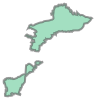

'Las Piñas'

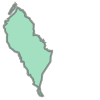

'Makati City'

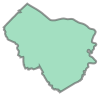

'Malabon'

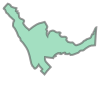

'Mandaluyong'

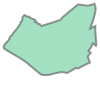

'Manila'

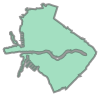

'Marikina'

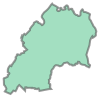

'Muntinlupa'

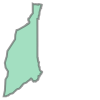

'Navotas'

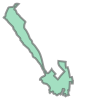

'Parañaque'

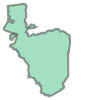

'Pasay City'

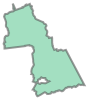

'Pasig City'

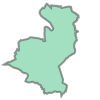

'Pateros'

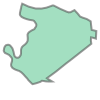

'Quezon City'

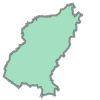

'San Juan'

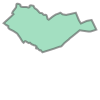

'Taguig'

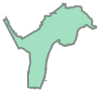

'Valenzuela'

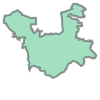

In [19]:
for idx, row in gadm_metro_manila.iterrows():
    display(row.NAME_2)
    display(row.geometry)

### Q5: Which two towns in metro manila has the smallest and largest land mass, respectively?

Show your solution.

In [20]:
gadm_metro_manila.iloc[[np.argmin(gadm_metro_manila.to_crs(3857).area)]]

,index,ID_0,COUNTRY,NAME_1,NL_NAME_1,ID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
12,972,PHL,Philippines,Metropolitan Manila,,PHL.47.13_1,Pateros,,,Lungsod|Siyudad,City,137606,PH.MM.PT,"MULTIPOLYGON (((121.06493 14.53952, 121.06468 14.53987, 121.06432 14.54024, 121.06401 14.54060, 121.06377 14.54085, 121.06350 14.54110, 121.06326 14.54125, 121.06309 14.54137, 121.06271 14.54149, ..."


In [21]:
gadm_metro_manila.iloc[[np.argmax(gadm_metro_manila.to_crs(3857).area)]]

,index,ID_0,COUNTRY,NAME_1,NL_NAME_1,ID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
13,973,PHL,Philippines,Metropolitan Manila,,PHL.47.14_1,Quezon City,,,Lungsod|Siyudad,City,137404,PH.MM.QE,"MULTIPOLYGON (((121.03670 14.60774, 121.03660 14.60766, 121.03558 14.60684, 121.03524 14.60657, 121.03513 14.60663, 121.03498 14.60671, 121.03481 14.60685, 121.03473 14.60694, 121.03467 14.60702, ..."


### e. OSMNx and graphs

This is a useful library for dealing with spatial graph network datasets. One good example of this is the street networks we see when travelling in land with a vehicle everyday. You can use this to model, analyze, and visualize street networks and other geospatial features from OSM. Let us walk thru an example.

In [22]:
COORD_TGT = (14.553514, 121.050110) # the globe tower @ bonifacio global city, taguig
COORD = COORD_TGT # you can replace this with any point within the region of interest
NAME_PLACE = "TGT"
G_drive = make_graph(origin=COORD, network_type="drive")
G_walk = make_graph(origin=COORD, network_type="walk")
G_bike = make_graph(origin=COORD, network_type="bike")

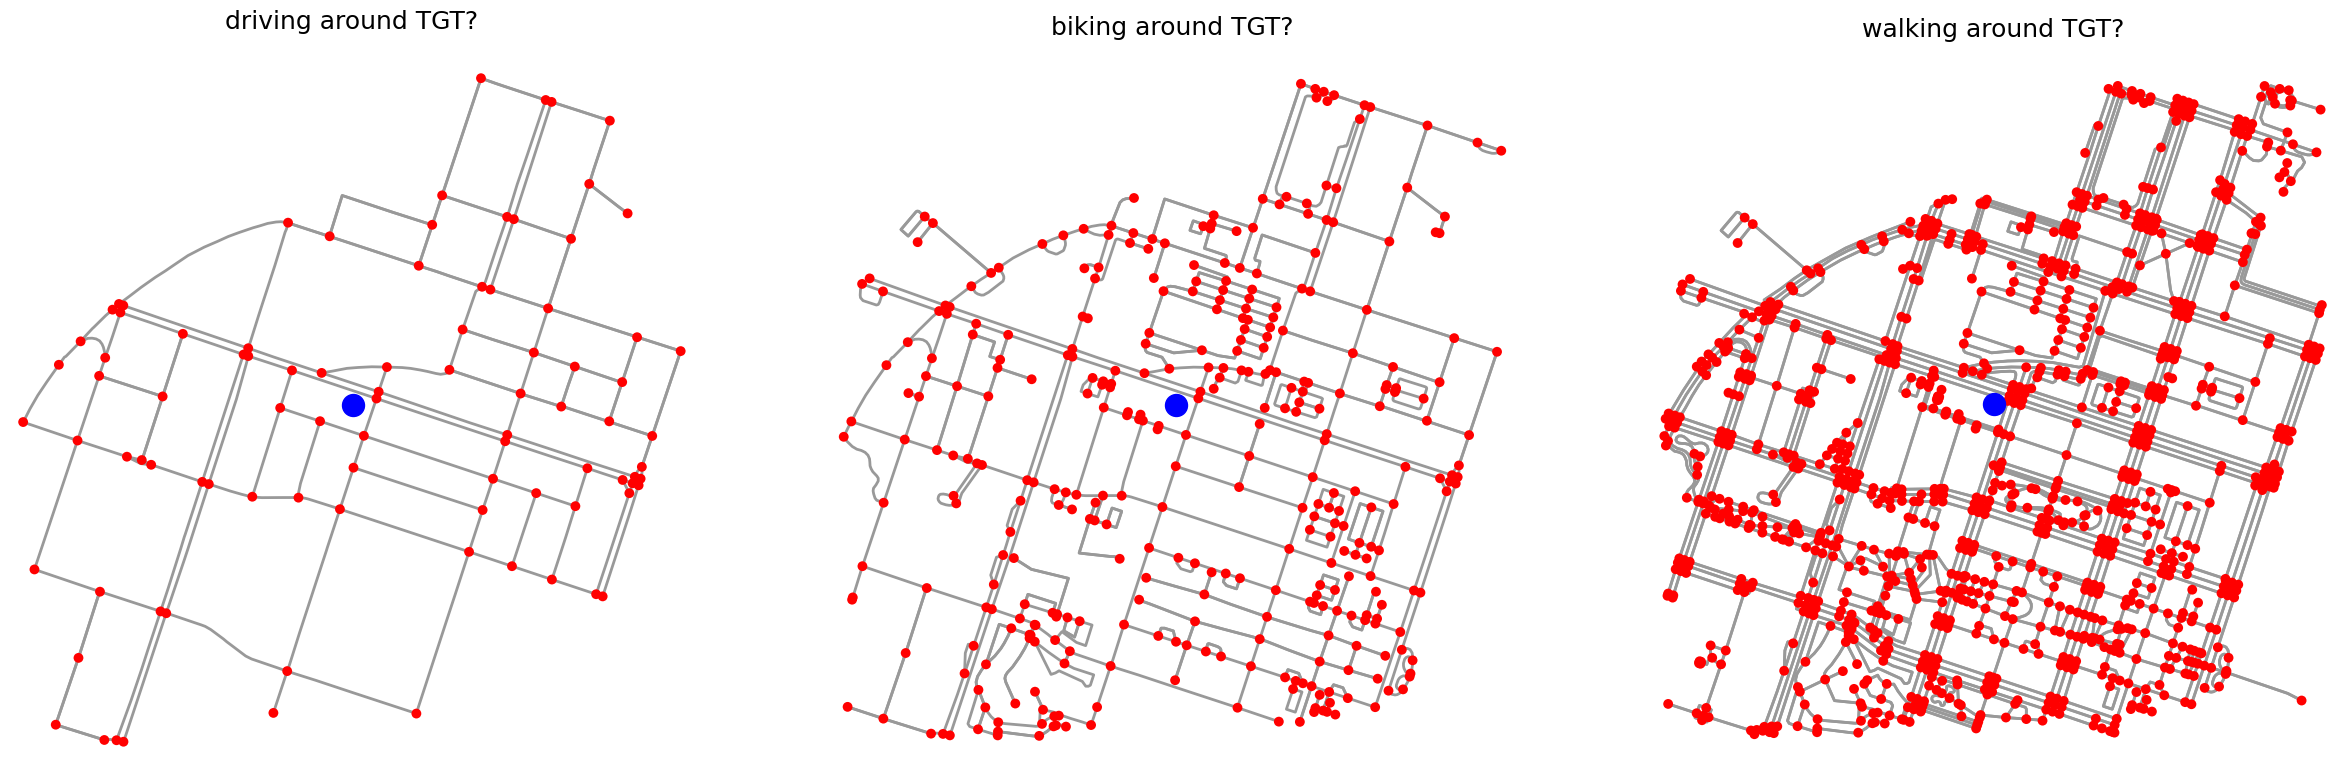

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(30, 30))
ox.plot_graph(G=G_drive, ax=ax[0], node_size=50, edge_linewidth=2, node_color="red", bgcolor="white", show=False, close=False)
ox.plot_graph(G=G_bike, ax=ax[1], node_size=50, edge_linewidth=2, node_color="red", bgcolor="white", show=False, close=False)
ox.plot_graph(G=G_walk, ax=ax[2], node_size=50, edge_linewidth=2, node_color="red", bgcolor="white", show=False, close=False)
ax[0].set_title(f"driving around {NAME_PLACE}?\n", fontsize=18)
ax[1].set_title(f"biking around {NAME_PLACE}?\n", fontsize=18)
ax[2].set_title(f"walking around {NAME_PLACE}?\n", fontsize=18)
ax[0].scatter(*COORD[::-1], c="blue", s=250)
ax[1].scatter(*COORD[::-1], c="blue", s=250)
ax[2].scatter(*COORD[::-1], c="blue", s=250);

- Walkable networks are denser than the driving networks
- Road networks like this can (and should) change over time

`NOTES`

These data representations isn't exclusive to Shapely, GeoPandas, and OSMNx. For instance, Snowflake (the data cloud company) has [its own](https://docs.snowflake.com/en/sql-reference/data-types-geospatial) geospatial data types and formats patterned to PostGIS. The more you work with SDS and understand its nuts and bolts, the more you realize that beyond these vast offerings of tools and software, there are common concepts and abstractions that needs to be mastered. Do yourself a favor and invest some time on the core concepts as well instead of purely memorizing the syntax of these modern tools.

### Q6: How large is each of the road networks displayed above?

Hint: Look at all the properties/attributes of the three G's.

- Answer for G_drive
- Answer for G_bike
- Answer for G_walk

## 5. Getting things done with **verbs**

### Buffering points and spatial matching

One of the common task in SDS is spatial matching. Say for example, you are given the task to find out **how many points of interest are within x kilometers from this origin point?**

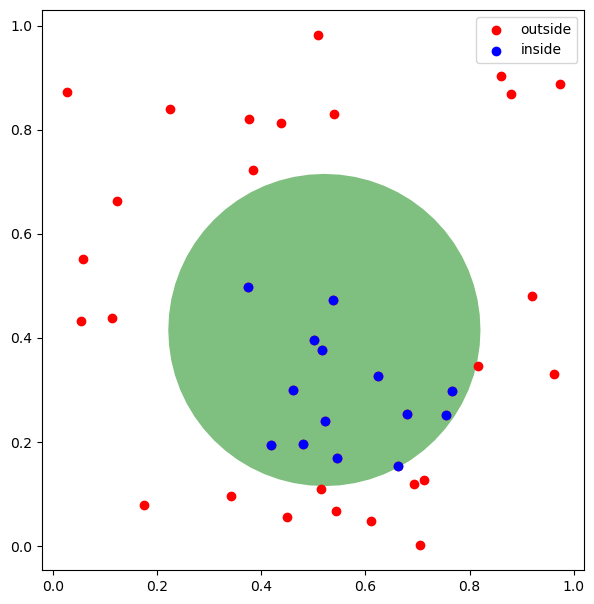

In [24]:
n = 40
points = make_spatial_data(n)[0]

fig, ax = plt.subplots(1, figsize=(7, 12))
gs_points = gpd.GeoSeries(points)
gs_points.plot(ax=ax, zorder=2, color="red")
mean_x = np.mean(list(map(lambda z: z.x, points)))
mean_y = np.mean(list(map(lambda z: z.y, points)))
mean_point = Point(mean_x, mean_y)
mean_point_buffered = gpd.GeoSeries(mean_point).buffer(3e-1)
bmask_within = [mean_point_buffered.contains(p)[0] for p in gs_points]
mean_point_buffered.plot(ax=ax, alpha=0.5, zorder=1, color="green")
gs_points.loc[bmask_within].plot(ax=ax, zorder=3, color="blue")
ax.legend(["outside", "inside"]);

### Q7: What if a rectangular buffer is needed? How many points will intersect above?

Hint: Look at shapely's docs and find something called **cap_style**.

- Answer for rectangular cap style

### Identifying the shortest path bet two points

In [26]:
COORD_WGC = (14.551534, 121.051751)
COORD_UPT = (14.556714, 121.054081)
orig_coord = COORD_TGT
dest_coord = COORD_WGC

orig_node = ox.distance.nearest_nodes(G_bike, *orig_coord[::-1])
dest_node = ox.distance.nearest_nodes(G_bike, *dest_coord[::-1])
route_od = ox.shortest_path(G_bike, orig_node, dest_node, weight="travel_time")
route_do = ox.shortest_path(G_bike, dest_node, orig_node, weight="travel_time")

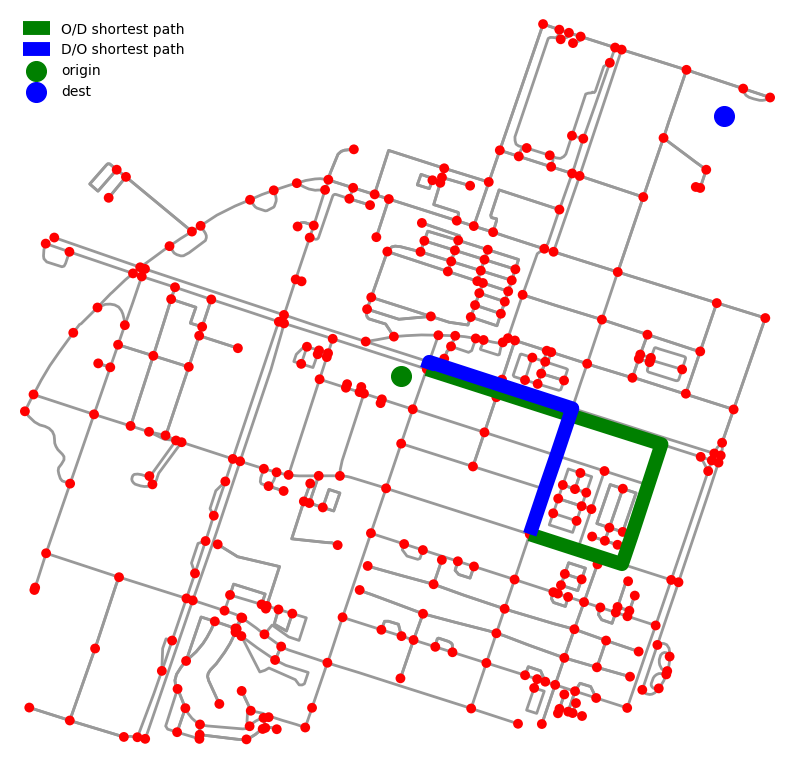

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ox.plot_graph(G=G_bike, ax=ax, node_size=50, edge_linewidth=2, node_color="red", bgcolor="white", show=False, close=False)
gpd.GeoSeries(shapely.geometry.LineString(get_coord_sequence(G_bike, route_od))).plot(ax=ax, color="green", linewidth=10)
gpd.GeoSeries(shapely.geometry.LineString(get_coord_sequence(G_bike, route_do))).plot(ax=ax, color="blue", linewidth=10)
ax.scatter(*COORD_TGT[::-1], c="green", s=200)
ax.scatter(*COORD_UPT[::-1], c="blue", s=200)
ax.legend(["__", "__", "O/D shortest path", "D/O shortest path", "origin", "dest"], edgecolor="white", loc="upper left");

`NOTES`

The shortest O-D path is not always the same D-O path in real-life! Most especially in driveable networks.

In [28]:
nodes_walk, edges_walk = ox.graph_to_gdfs(G_walk)
print(f"nodes_walk: {type(nodes_walk)}\n", f"edges_walk: {type(nodes_walk)}")

nodes_walk: <class 'geopandas.geodataframe.GeoDataFrame'>
 edges_walk: <class 'geopandas.geodataframe.GeoDataFrame'>


In [29]:
nodes_walk.head()

,y,x,highway,street_count,geometry
osmid,,,,,
32542716,14.549276,121.046034,traffic_signals,4,POINT (121.04603 14.54928)
32542900,14.550650,121.051385,crossing,4,POINT (121.05138 14.55065)
32542911,14.555931,121.049215,NaN,4,POINT (121.04922 14.55593)
32542971,14.553288,121.045587,traffic_signals,4,POINT (121.04559 14.55329)
32542973,14.554047,121.046076,NaN,3,POINT (121.04608 14.55405)


In [30]:
edges_walk.head()

osmid lanes         name       highway maxspeed  \
u        v          key                                                        
32542716 6976286547 0      4940257     4   4th Avenue  unclassified       40   
         6976286545 0     32488152     4  26th Street      tertiary       40   
         6976286544 0    814837410     4  26th Street      tertiary       40   
         6976286546 0    814837411     4   4th Avenue  unclassified       40   
32542900 271196480  0    690148299     3   9th Avenue      tertiary       40   

                         oneway reversed  length  \
u        v          key                            
32542716 6976286547 0     False    False  12.259   
         6976286545 0     False     True  11.169   
         6976286544 0     False    False   7.996   
         6976286546 0     False     True   7.419   
32542900 271196480  0     False     True  35.204   

                                                                    geometry  \
u        v          key                                                        
32542716 6976286547 0    LINESTRING (121.04603 14.54928, 121.04607 14.54938)   
         6976286545 0    LINESTRING (121.04603 14.54928, 121.04594 14.54931)   
         6976286544 0    LINESTRING (121.04603 14.54928, 121.04610 14.54925)   
         6976286546 0    LINESTRING (121.04603 14.54928, 121.04601 14.54921)   
32542900 271196480  0    LINESTRING (121.05138 14.55065, 121.05128 14.55035)   

                        access width service tunnel bridge  
u        v          key                                     
32542716 6976286547 0      NaN   NaN     NaN    NaN    NaN  
         6976286545 0      NaN   NaN     NaN    NaN    NaN  
         6976286544 0      NaN   NaN     NaN    NaN    NaN  
         6976286546 0      NaN   NaN     NaN    NaN    NaN  
32542900 271196480  0      NaN   NaN     NaN    NaN    NaN

## 6. References [WIP]

1. https://carto.com/what-is-spatial-data-science